## Importando lib SB3

In [2]:
from stable_baselines3 import PPO, DQN, A2C
import gymnasium as gym
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy

tmp_path = "./results/"
new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])

env = gym.make("CartPole-v1")
model = A2C(policy = "MlpPolicy", env = env)

model.set_logger(new_logger)
model.learn(total_timesteps=100_000)

mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

Logging to ./results/
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.7     |
|    ep_rew_mean        | 22.7     |
| time/                 |          |
|    fps                | 258      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.688   |
|    explained_variance | 0.0278   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.69     |
|    value_loss         | 8.05     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 24.2     |
|    ep_rew_mean        | 24.2     |
| time/                 |          |
|    fps                | 273      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/        

In [ ]:
print('modelo treinado')
env = gym.make("CartPole-v1", render_mode='human')
(obs,_) = env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()

In [ ]:
def train(alpha, 
          gamma, 
          epsilon, 
          epsilon_min, 
          epsilon_decay, 
          episodes=500,
          verbose=False,
          algorithm='qlearning',
          save=False,
          path=None,
          window=25,
          C=None,
          env=None):
    
    if algorithm == 'qlearning':
        agent = AgentQLearning(env=env,
                    alpha=alpha, 
                    gamma=gamma, 
                    epsilon=epsilon, 
                    epsilon_min=epsilon_min, 
                    epsilon_decay=epsilon_decay)
    elif algorithm == 'sarsa':
        agent = AgentSarsa(env=env,
                    alpha=alpha, 
                    gamma=gamma, 
                    epsilon=epsilon, 
                    epsilon_min=epsilon_min, 
                    epsilon_decay=epsilon_decay)
    elif algorithm == 'deepqlearning': # DQN
        action_size = env.action_space.n
        observation_size = env.observation_space.shape[0]
        fc1_dim = 512
        fc2_dim = 512  
        agent = AgentDQN(action_size=action_size,
              observation_size=observation_size,
              fc1_dim=fc1_dim,
              fc2_dim=fc2_dim,
              lr=4e-4,
              gamma=gamma,
              epsilon=epsilon,      
              epsilon_min=epsilon_min, 
              epsilon_decay=epsilon_decay,
              batch_size=64,
              device='cuda',
              env=env)
    elif algorithm == "deepqlearning2": # Double DQN
        action_size = env.action_space.n
        observation_size = env.observation_space.shape[0]
        fc1_dim = 512
        fc2_dim = 512  
        agent = AgentDQN2(action_size=action_size,
              observation_size=observation_size,
              fc1_dim=fc1_dim,
              fc2_dim=fc2_dim,
              lr=alpha,
              gamma=gamma,
              epsilon=epsilon,      
              epsilon_min=epsilon_min, 
              epsilon_decay=epsilon_decay,
              batch_size=64,
              C=C,
              device='cuda',
              env=env)
    
    total_rewards = []
    mean_rewards = []
    if (algorithm != 'deepqlearning') and (algorithm != 'deepqlearning2'):
        for episode in tqdm(range(episodes),
                            disable=not verbose):
            state, _ = env.reset()
            done = False
            total_reward = 0
            step = 0
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                done = terminated or (step >= 1_200)
                agent.learn(state, action, reward, next_state)
                total_reward += reward
                state = next_state
                step += 1
                # print(action)
                
            agent.update_epsilon()
            total_rewards.append(total_reward)
            
            if window:
                if (episode+1) % window == 0:
                    mean_reward = np.mean(total_rewards[-window:])
                    mean_rewards.append(mean_reward)
                    if verbose and (episode+1) % 100 == 0:
                        print(f"Episode {episode + 1}: {mean_reward}")
    else:
        score_history = []
        avg_score_history = []
        all_step = 0
        for episode in tqdm(range(episodes),
                            disable=not verbose):
            obs = env.reset()[0]
            episode_over = False
            score = 0
            step = 0
            while not episode_over:
                obs = torch.tensor(obs)
                action = agent.get_action(obs)
                next_obs, reward, terminated, truncated, info = env.step(action)
                episode_over = terminated or truncated or (step >= 1_000)
                agent.store_transition(obs, action, reward, next_obs, episode_over)
                if algorithm == 'deepqlearning2':
                    agent.learn(all_step)
                else:
                    agent.learn()
                next_obs = torch.tensor(next_obs)
                score += reward
                obs = next_obs
                step += 1
                all_step += 1
                
            score_history.append(score)
            
            if window:
                if episode % window == 0:
                    avg_score = np.mean(score_history[-window:])
                    avg_score_history.append(avg_score)
                    print('episode: ', episode,'score: %.1f' % score,
                        'average score %.1f' % avg_score)
        mean_rewards = avg_score_history
                
    if save:
        if algorithm == 'qlearning':
            if path is None:
                path = f"./saved_models/model_{algorithm}_{env.env.env.spec.name}.npy"
            agent.save(path)
        if algorithm == 'deepqlearning' or algorithm == 'deepqlearning2':
            if path is None:
                path = f"./saved_models/model_{algorithm}_{env.env.env.spec.name}.pth"
            policy = agent.policy
            torch.save(policy.state_dict(), path)
    
    return mean_rewards

In [3]:
# Check de sanidade

action_size = env.action_space.n
observation_size = env.observation_space.shape[0]
fc1_dim = 512
fc2_dim = 512  

agent = AgentDQN2(action_size=action_size,
              observation_size=observation_size,
              fc1_dim=fc1_dim,
              fc2_dim=fc2_dim,
              lr=4e-3,
              gamma=0.99,
              epsilon=1.0,      
              epsilon_min=0.01, 
              epsilon_decay=0.999,
              batch_size=64,
              device='cuda',
              env=env)

policy = agent.policy
torch.save(policy.state_dict(), './saved_models/policy.pth')

8


### Loop de treino

In [10]:
episodes_default = 250

alpha_default = 4e-4 # variar de 0.1 a 0.9 com 10 pontos
gamma_default = 0.99
epsilon_default = 1.0
epsilon_min_default = 0.01 # variar de 0.001 a 0.4 com 10 pontos
epsilon_decay_default = 0.999

n_batches = 5
n_episodes = episodes_default
window = 25

results_alg = {}
for algorithm in ['deepqlearning2']:
    print(f"Training with algorithm = {algorithm}")
    rewards_alg = []
    save = False
    for _ in range(n_batches):
        if _ == n_batches - 1:
            save = True
        rewards_alg.append(train(alpha=alpha_default, 
                                 gamma=gamma_default, 
                                 epsilon=epsilon_default, 
                                 epsilon_min=epsilon_min_default, 
                                 epsilon_decay=epsilon_decay_default, 
                                 episodes=n_episodes,
                                 algorithm=algorithm,
                                 save=save,
                                 verbose=True,
                                 C=100,
                                 window=window,
                                 env=env))
    rewards_alg_mean = np.mean(rewards_alg, axis=0)
    rewards_alg_std = np.std(rewards_alg, axis=0)

    print(f"Mean reward: {rewards_alg_mean[-1]}")
    print(f"Std reward: {rewards_alg_std[-1]}")
    print("-----------------------------------")
    results_alg[algorithm] = (rewards_alg_mean, rewards_alg_std)

Training with algorithm = deepqlearning2
8


  0%|          | 0/250 [00:00<?, ?it/s]C:\Users\gabri\AppData\Local\Temp\ipykernel_27120\2039567169.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs)
  0%|          | 1/250 [00:00<01:28,  2.82it/s]

episode:  0 score: -384.5 average score -384.5


 10%|█         | 26/250 [00:25<07:30,  2.01s/it]

episode:  25 score: -87.8 average score -150.9


 20%|██        | 51/250 [01:42<12:44,  3.84s/it]

episode:  50 score: -42.3 average score -59.9


 30%|███       | 76/250 [03:23<14:58,  5.16s/it]

episode:  75 score: -36.5 average score -31.0


 40%|████      | 101/250 [05:37<12:12,  4.92s/it]

episode:  100 score: -512.2 average score -40.8


 50%|█████     | 126/250 [07:42<09:48,  4.75s/it]

episode:  125 score: -27.8 average score -44.0


 60%|██████    | 151/250 [09:46<06:41,  4.05s/it]

episode:  150 score: 208.5 average score 4.0


 70%|███████   | 176/250 [10:43<01:31,  1.24s/it]

episode:  175 score: 63.4 average score 146.7


 80%|████████  | 201/250 [11:12<00:42,  1.14it/s]

episode:  200 score: -104.8 average score -25.6


 90%|█████████ | 226/250 [12:05<01:13,  3.06s/it]

episode:  225 score: 11.1 average score 23.3


100%|██████████| 250/250 [13:01<00:00,  3.13s/it]


8


  0%|          | 1/250 [00:00<00:52,  4.71it/s]

episode:  0 score: -103.8 average score -103.8


 10%|█         | 26/250 [00:20<03:30,  1.06it/s]

episode:  25 score: -128.7 average score -179.1


 20%|██        | 51/250 [00:52<04:34,  1.38s/it]

episode:  50 score: -94.9 average score -120.9


 30%|███       | 76/250 [01:41<05:10,  1.79s/it]

episode:  75 score: -190.2 average score -126.1


 40%|████      | 101/250 [02:37<11:43,  4.72s/it]

episode:  100 score: -116.2 average score -142.4


 50%|█████     | 126/250 [05:47<18:58,  9.18s/it]

episode:  125 score: -48.3 average score -92.0


 60%|██████    | 151/250 [09:05<08:29,  5.15s/it]

episode:  150 score: -44.2 average score -43.2


 70%|███████   | 176/250 [11:50<01:59,  1.61s/it]

episode:  175 score: -159.6 average score -64.6


 80%|████████  | 201/250 [14:15<05:23,  6.61s/it]

episode:  200 score: -156.1 average score -83.6


 90%|█████████ | 226/250 [16:25<02:02,  5.09s/it]

episode:  225 score: 255.6 average score 155.4


100%|██████████| 250/250 [18:48<00:00,  4.51s/it]


8


  0%|          | 1/250 [00:00<01:17,  3.20it/s]

episode:  0 score: -157.6 average score -157.6


 10%|█         | 26/250 [00:38<09:26,  2.53s/it]

episode:  25 score: -244.8 average score -230.5


 20%|██        | 51/250 [03:55<27:16,  8.22s/it]

episode:  50 score: -15.3 average score -41.8


 30%|███       | 76/250 [05:47<06:21,  2.19s/it]

episode:  75 score: -55.8 average score -48.3


 40%|████      | 101/250 [07:40<15:04,  6.07s/it]

episode:  100 score: -179.2 average score -29.7


 50%|█████     | 126/250 [10:05<11:36,  5.62s/it]

episode:  125 score: 236.0 average score 82.0


 60%|██████    | 151/250 [12:37<10:15,  6.22s/it]

episode:  150 score: 186.9 average score 191.0


 70%|███████   | 176/250 [14:17<04:34,  3.71s/it]

episode:  175 score: 255.1 average score 169.8


 80%|████████  | 201/250 [15:49<02:36,  3.19s/it]

episode:  200 score: 268.0 average score 104.1


 90%|█████████ | 226/250 [17:32<02:04,  5.17s/it]

episode:  225 score: 115.7 average score 215.5


100%|██████████| 250/250 [19:05<00:00,  4.58s/it]


8


  0%|          | 0/250 [00:00<?, ?it/s]

episode:  0 score: -213.2 average score -213.2


 10%|█         | 26/250 [01:41<29:06,  7.80s/it]

episode:  25 score: -28.7 average score -136.1


 20%|██        | 51/250 [03:29<07:04,  2.14s/it]

episode:  50 score: -32.1 average score -68.5


 30%|███       | 76/250 [07:02<28:06,  9.69s/it]

episode:  75 score: 9.4 average score -25.9


 40%|████      | 101/250 [10:00<16:37,  6.69s/it]

episode:  100 score: 218.0 average score 83.5


 50%|█████     | 126/250 [11:59<07:46,  3.76s/it]

episode:  125 score: 256.2 average score 199.4


 60%|██████    | 151/250 [14:02<08:08,  4.94s/it]

episode:  150 score: 222.1 average score 185.1


 70%|███████   | 176/250 [16:02<04:34,  3.71s/it]

episode:  175 score: 231.9 average score 133.5


 80%|████████  | 201/250 [17:05<01:53,  2.32s/it]

episode:  200 score: 242.4 average score 239.0


 90%|█████████ | 226/250 [18:24<01:31,  3.82s/it]

episode:  225 score: 251.3 average score 252.7


100%|██████████| 250/250 [19:39<00:00,  4.72s/it]


8


  0%|          | 1/250 [00:00<01:01,  4.06it/s]

episode:  0 score: -410.0 average score -410.0


 10%|█         | 26/250 [00:52<09:34,  2.56s/it]

episode:  25 score: -136.5 average score -168.1


 20%|██        | 51/250 [02:31<09:56,  3.00s/it]

episode:  50 score: 276.5 average score -15.8


 30%|███       | 76/250 [03:39<04:18,  1.49s/it]

episode:  75 score: 14.9 average score 175.8


 40%|████      | 101/250 [04:21<06:33,  2.64s/it]

episode:  100 score: 280.6 average score -25.5


 50%|█████     | 126/250 [05:53<06:00,  2.90s/it]

episode:  125 score: 230.5 average score 217.4


 60%|██████    | 151/250 [07:38<06:09,  3.73s/it]

episode:  150 score: 251.3 average score 184.2


 70%|███████   | 176/250 [09:11<02:50,  2.30s/it]

episode:  175 score: 302.1 average score 248.5


 80%|████████  | 201/250 [10:21<01:49,  2.24s/it]

episode:  200 score: 251.8 average score 241.2


 90%|█████████ | 226/250 [11:13<00:45,  1.89s/it]

episode:  225 score: 290.1 average score 203.4


100%|██████████| 250/250 [11:59<00:00,  2.88s/it]

Mean reward: 170.07439885946843
Std reward: 79.69530382693415
-----------------------------------


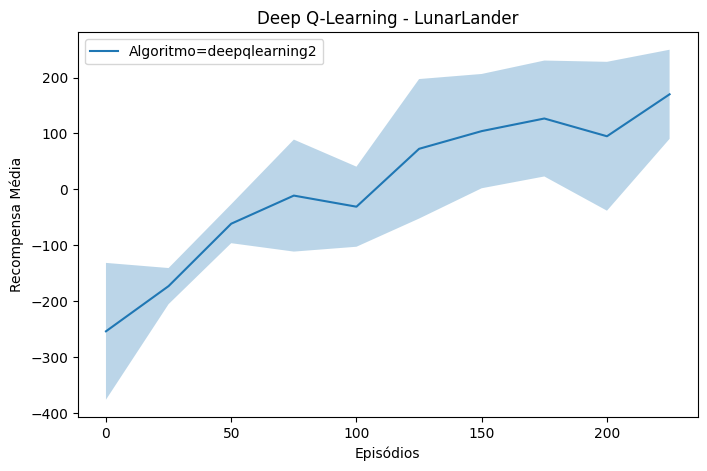

In [11]:
# Criar figura
plt.figure(figsize=(8, 5))

for alg in ['deepqlearning2']:#, 'sarsa']:
    rewards_alg_mean, rewards_alg_std = results_alg[alg]
    rewards_alg_mean = rewards_alg_mean
    rewards_alg_std = rewards_alg_std
    x_values = np.array(range(len(rewards_alg_mean))) * window
    sns.lineplot(x=x_values, y=rewards_alg_mean, label="Algoritmo=" + str(alg))
    plt.fill_between(x_values, rewards_alg_mean - rewards_alg_std, rewards_alg_mean + rewards_alg_std, alpha=0.3)

# Configurações
plt.xlabel("Episódios")
plt.ylabel("Recompensa Média")
plt.title(r"Deep Q-Learning - " + f"{env.env.env.spec.name}")
plt.legend()
plt.show()

## Definição de meta

Para o contexto atual de testes, vamos definir nossa meta em 200 pontos. Ou seja, o agente deve ser capaz de atingir uma recompensa média de 200 pontos.

## Conclusão parcial 

Para o deep q learning, podemos visualizar que o gráfico de recompensa converge para valores satisfatórios, considerando a meta de 200 pontos para a curva de treinamento.

## Hiper-parâmetros

Para o deep q learning, os hiper-parâmetros foram os seguintes:

$\alpha = 4-e4$

$\gamma = 0.99$

$\epsilon = 1.0$

$\epsilon_{min} = 0.01$

$\epsilon_{decay} = 0.999$

## Inferência

Vamos visualizar agora o comportamento do agente para o modo de inferência, isto é, com a rede já treinada.

In [12]:
n_states = env.observation_space.shape[0]
action_size = env.action_space.n

fc1_dim = 512
fc2_dim = 512
action_size = env.action_space.n
policy = NeuralNetwork(fc1_dim=fc1_dim,
                        fc2_dim=fc2_dim,
                        input_dim=n_states,
                        output_dim=action_size).to('cuda')

policy.load_state_dict(torch.load('./saved_models/model_deepqlearning2_LunarLander.pth'))
policy.eval()  # Coloca o modelo em modo de avaliação (sem dropout, etc.)

NeuralNetwork(
  (fc1): Linear(in_features=8, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=4, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=-1)
)

In [13]:
# 1. Criar o ambiente
env = gym.make(env_name)#, render_mode='human')

n_batches = 5

all_rewards_deepqlearning = []
num_episodes = 100

for idx in tqdm(range(n_batches)):
    reward_deepqlearning = []
    for i in tqdm(range(num_episodes)):
        state, _ = env.reset()
        done = False
        score = 0
        step = 0
        while not done:
            # state_ = agent_loaded_deepqlearning.transform_state(state)
            action = torch.argmax(policy(torch.Tensor(state).to("cuda"))).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated 
            score += reward
            state = next_state
            step += 1
        # print(score)
            
        reward_deepqlearning.append(score)
    
    all_rewards_deepqlearning.append(reward_deepqlearning)
    env.close()

100%|██████████| 5/5 [01:53<00:00, 22.63s/it]


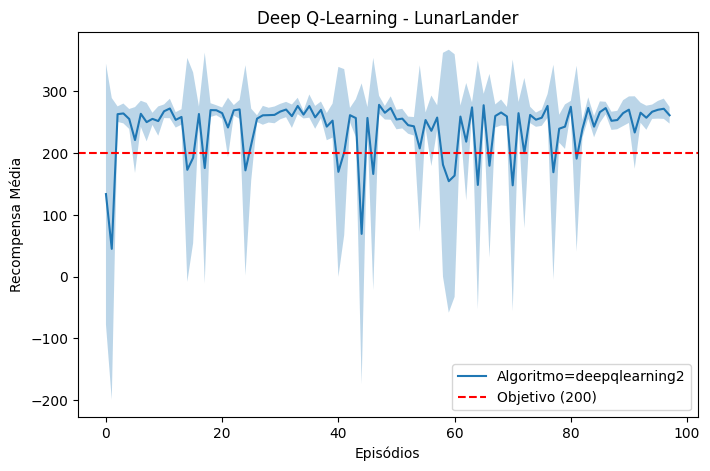

In [14]:
# Criar figura
plt.figure(figsize=(8, 5))

results_alg = {
    'deepqlearning2': (np.mean(all_rewards_deepqlearning, axis=0), np.std(all_rewards_deepqlearning, axis=0)),
    # 'qlearning': (np.mean(all_rewards_qlearning, axis=0), np.std(all_rewards_qlearning, axis=0))
    
}

for alg in ['deepqlearning2']:#, 'sarsa']:
    rewards_alg_mean, rewards_alg_std = results_alg[alg]
    rewards_alg_mean = rewards_alg_mean[2:]
    rewards_alg_std = rewards_alg_std[2:]
    x_values = np.array(range(len(rewards_alg_mean))) 
    sns.lineplot(x=x_values, y=rewards_alg_mean, label="Algoritmo=" + str(alg))
    plt.fill_between(x_values, rewards_alg_mean - rewards_alg_std, rewards_alg_mean + rewards_alg_std, alpha=0.3)
    # Traçar uma reta vermelha horizontal no valor de -200
plt.axhline(y=200, color='r', linestyle='--', label="Objetivo (200)")

# Configurações
plt.xlabel("Episódios")
plt.ylabel("Recompensa Média")
plt.title(r"Deep Q-Learning - " + f"{env.env.env.spec.name}")
plt.legend()
plt.show()

## Renderizando a atuação do agente

In [15]:
# 1. Criar o ambiente
env = gym.make(env_name, render_mode='human')

n_batches = 1
num_episodes = 5

for idx in tqdm(range(n_batches)):
    for i in tqdm(range(num_episodes)):
        state, _ = env.reset()
        done = False
        score = 0
        step = 0
        while not done:
            action = torch.argmax(policy(torch.Tensor(state).to("cuda"))).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated 
            score += reward
            state = next_state
            step += 1
    env.close()

100%|██████████| 1/1 [00:27<00:00, 27.34s/it]
